In [92]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import matplotlib.pyplot as plt
from training.util import plot_losses, GaussWrapper
from training.regresssion import RegressionResults, plot_calibration, plot_table
from training import toy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
device = torch.device("cpu")

In [94]:
noise = torch.tensor(0.02).to(device) # 0.02
learn_var = False
def sgd(lr):
    return lambda parameters: torch.optim.SGD(parameters, lr)

In [95]:
def plot_grid(dataset, testset, min, max, models, device):
    fig, axes = plt.subplots(nrows=4, ncols=len(models), figsize=(5 * len(models), 15))
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])
    results = []
    for i, (name, model, samples) in enumerate(models):
        plot_losses(name, model.all_losses(), axes[0, i])
        result = RegressionResults(testloader, name, model.infer, samples, device, fit_gaussian=False, target_mean=dataset.y_mean, target_std = dataset.y_std)
        dataset.plot_predictions(min, max, model.infer, samples, axes[1, i], dataset=None, alpha = 0.1 if samples > 10 else 1)
        dataset.plot_predictions(min, max, model.infer, samples, axes[2, i], dataset=testset, alpha = 0.1 if samples > 10 else 1)
        plot_calibration(name, result, axes[3, i])
        results.append(result)

    return fig, results

def store_results(dataset, testset, min, max, models, device):
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])
    for i, (name, model, samples) in enumerate(models):
        result = RegressionResults(testloader, name, model.infer, samples, device, fit_gaussian=False, target_mean=dataset.y_mean, target_std = dataset.y_std)
        fig, ax = plt.subplots(1, 1)
        dataset.plot_predictions(min, max, model.infer, samples, ax, dataset=None, alpha = 0.1 if samples > 10 else 1)
        fig.tight_layout(pad=0)
        fig.savefig(f"results/toy/regression/{name}_plot.pdf")

        fig, ax = plt.subplots(1, 1)
        plot_calibration(None, result, ax, include_text=False)
        fig.tight_layout(pad=0)
        fig.savefig(f"results/toy/regression/{name}_calibration.pdf")

In [96]:
from training.pp import PointPredictor
from training.swag import SwagModel
from training.ensemble import Ensemble
from training.bbb import GaussianPrior, BBBModel
from training.gp import GaussianProcess

def train_models(dataset, batch_size):
    torch.manual_seed(42)
    trainloader = torch.utils.data.DataLoader(dataset.trainset, batch_size=batch_size)


    torch.manual_seed(42)
    gp = GaussianProcess(dataset.normalized_xs, dataset.normalized_ys, noise / dataset.y_std**2)
    gp.train_model(100, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    pp = GaussWrapper(PointPredictor(layers), noise, learn_var)
    pp.train_model(100, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    swag_config = {
        "start_epoch": 70,
        "update_every_batches": len(trainloader),
        "deviation_samples": 30
    }
    swag = GaussWrapper(SwagModel(layers, swag_config), noise, learn_var)
    swag.train_model(100, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    diag_swag_config = {
        "start_epoch": 70,
        "update_every_batches": len(trainloader),
        "deviation_samples": 30,
        "use_low_rank_cov": False
    }
    diag_swag = GaussWrapper(SwagModel(layers, diag_swag_config), noise, learn_var)
    diag_swag.train_model(100, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    ensemble = Ensemble([GaussWrapper(PointPredictor(layers), noise, learn_var) for _ in range(10)])
    ensemble.train_model(100, sgd(0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    mc_dropout = GaussWrapper(PointPredictor(layers), noise, learn_var)
    mc_dropout.train_model(200, sgd(0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    bbb_prior = GaussianPrior(0, 1)
    layers = [
        ("v_fc", (1, 32, bbb_prior)),
        ("relu", ()),
        ("v_fc", (32, 32, bbb_prior)),
        ("relu", ()),
        ("v_fc", (32, 32, bbb_prior)),
        ("relu", ()),
        ("v_fc", (32, 1, bbb_prior))
    ]
    bbb = GaussWrapper(BBBModel(layers), noise, learn_var)
    bbb.train_model(200, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("v_fc", (32, 1, bbb_prior))
    ]
    bbb_ll = GaussWrapper(BBBModel(layers), noise, learn_var)
    bbb_ll.train_model(200, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5)

    return [gp, pp, ensemble, swag, diag_swag, mc_dropout, bbb, bbb_ll]

Epoch 0: loss 1.1957824230194092
Epoch 10: loss 1.136074423789978
Epoch 20: loss 1.1274712085723877
Epoch 30: loss 1.1022239923477173
Epoch 40: loss 1.069035530090332
Epoch 50: loss 1.0352400541305542
Epoch 60: loss 0.9973661303520203
Epoch 70: loss 0.8972219228744507
Epoch 80: loss 0.6959348917007446
Epoch 90: loss 0.44623228907585144
Epoch 100: loss 0.21427324414253235
Epoch 110: loss 0.2817665934562683
Epoch 120: loss 0.04452943801879883
Epoch 130: loss 0.029089922085404396
Epoch 140: loss 0.021831460297107697
Epoch 150: loss 0.021627623587846756
Epoch 160: loss 0.016891058534383774
Epoch 170: loss 0.02080206200480461
Epoch 180: loss 0.006062501575797796
Epoch 190: loss 0.01205946784466505
Final loss 0.007522991392761469


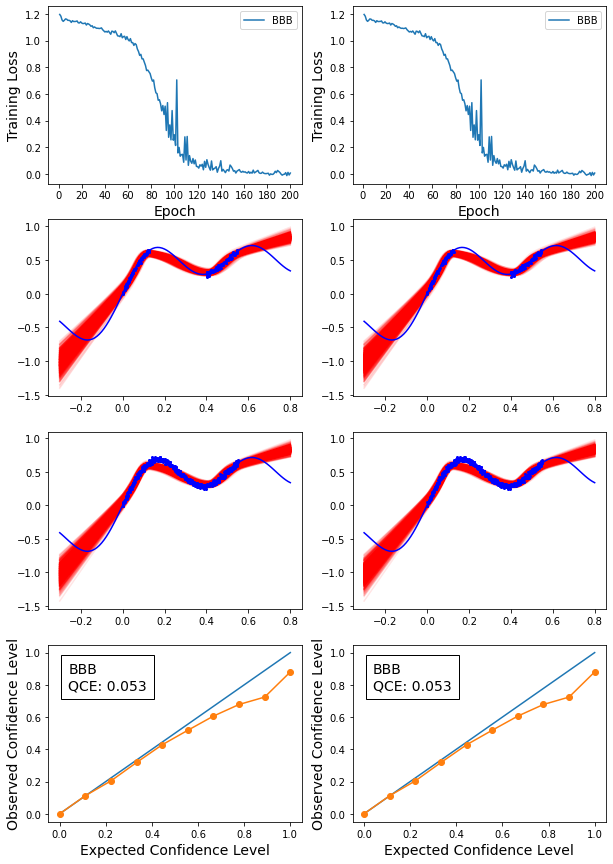

In [140]:
torch.manual_seed(42)

dataset = toy.TrigonometricToyDataset([(0, 0.13, 100), (0.4, 0.55, 100)], noise)
trainloader = torch.utils.data.DataLoader(dataset.trainset, batch_size=20)
testset = dataset.generate_testset(0.0, 0.55, 500, noise)
testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

bbb_prior = GaussianPrior(0, 1)
layers = [
    ("v_fc", (1, 32, bbb_prior)),
    ("relu", ()),
    ("v_fc", (32, 32, bbb_prior)),
    ("relu", ()),
    ("v_fc", (32, 32, bbb_prior)),
    ("relu", ()),
    ("v_fc", (32, 1, bbb_prior))
]
bbb = GaussWrapper(BBBModel(layers), noise, learn_var)
kl_grads, data_grads = bbb.train_model(200, sgd(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=10, kl_rescaling=0.1, mc_samples=2)

fig, results = plot_grid(dataset, testset, -0.3, 0.8, [("BBB", bbb, 1000),("BBB", bbb, 1000)], device)

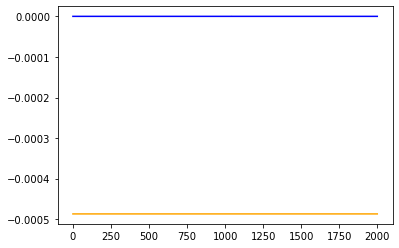

In [139]:
data_mad = (data_grads - data_grads.median(dim=1)[0].unsqueeze(-1)).abs().median(dim=1)[0]
#plt.plot(data_mad, color="blue")
plt.plot(data_grads.median(dim=1)[0], color="blue")
plt.plot(kl_grads.median(dim=1)[0], color="orange")

torch.Size([2209])
tensor(0.0372, grad_fn=<MinBackward1>)
tensor(0.0485, grad_fn=<MeanBackward0>)
tensor(0.0486, grad_fn=<MaxBackward1>)
tensor(0.0081)


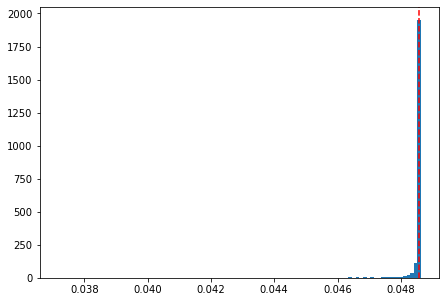

In [103]:
result = torch.tensor([])
for module in bbb.mean.model:
    if (hasattr(module, "sigmas")):
        result = torch.cat([result, module.sigmas()])

plt.hist(result.detach().numpy(), bins=100)[1]
plt.axvline(torch.nn.functional.softplus(torch.tensor(-3.0)), color="red", linestyle="--")
plt.tight_layout(pad=0)
#plt.savefig("results/vi/sigma_hist_1.pdf")
print(result.shape)
print(result.min())
print(result.mean())
print(result.max())
print((result < 0.046).sum() / 2209)

Epoch 0: loss 1.488417625427246
Epoch 10: loss 1.3010597229003906
Epoch 20: loss 0.9673271775245667
Epoch 30: loss 0.5684577822685242
Epoch 40: loss 0.422666996717453
Epoch 50: loss 0.30871787667274475
Epoch 60: loss 0.25508564710617065
Epoch 70: loss 0.24674461781978607
Epoch 80: loss 0.23996834456920624
Epoch 90: loss 0.2453131079673767
Epoch 100: loss 0.23723658919334412
Epoch 110: loss 0.23997469246387482
Epoch 120: loss 0.23747098445892334
Epoch 130: loss 0.23509502410888672
Epoch 140: loss 0.23470400273799896
Epoch 150: loss 0.23701506853103638
Epoch 160: loss 0.2395467907190323
Epoch 170: loss 0.23405666649341583
Epoch 180: loss 0.23300784826278687
Epoch 190: loss 0.23144583404064178
Final loss 0.2286287248134613


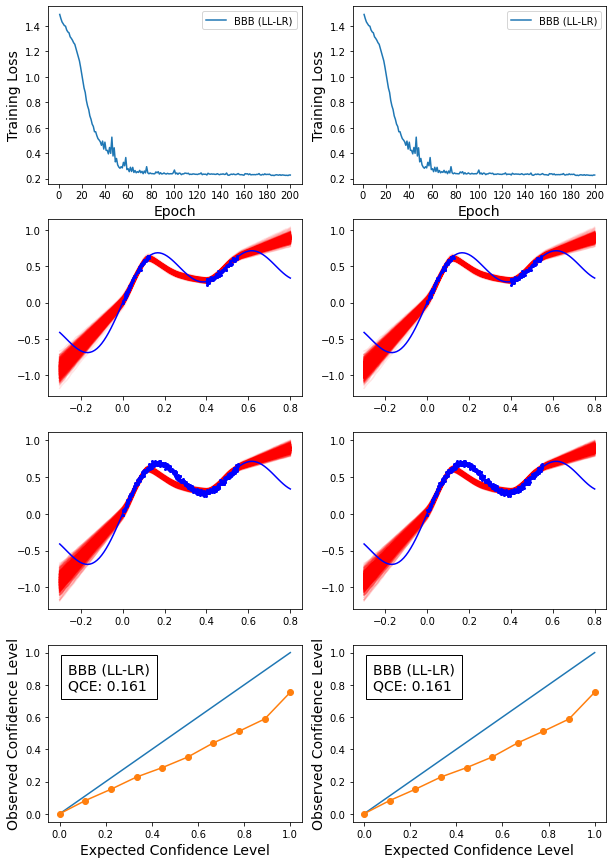

In [16]:
torch.manual_seed(42)

dataset = toy.TrigonometricToyDataset([(0, 0.13, 100), (0.4, 0.55, 100)], noise)
trainloader = torch.utils.data.DataLoader(dataset.trainset, batch_size=20)
testset = dataset.generate_testset(0.0, 0.55, 500, noise)
testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

bbb_prior = GaussianPrior(0, 1)
layers = [
    ("fc", (1, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("vlr_fc", (32, 32, 10, 1)),
    ("relu", ()),
    ("vlr_fc", (32, 1, 10, 1))
]
bbb_ll = GaussWrapper(BBBModel(layers), noise, learn_var)
bbb_ll.train_model(200, sgd(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=10, kl_rescaling=1)

fig, results = plot_grid(dataset, testset, -0.3, 0.8, [("BBB (LL-LR)", bbb_ll, 1000),("BBB (LL-LR)", bbb_ll, 1000)], device)

Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  w

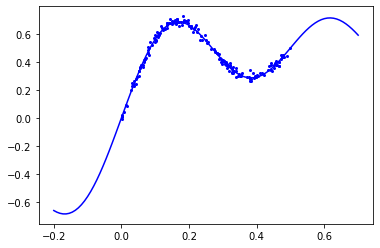

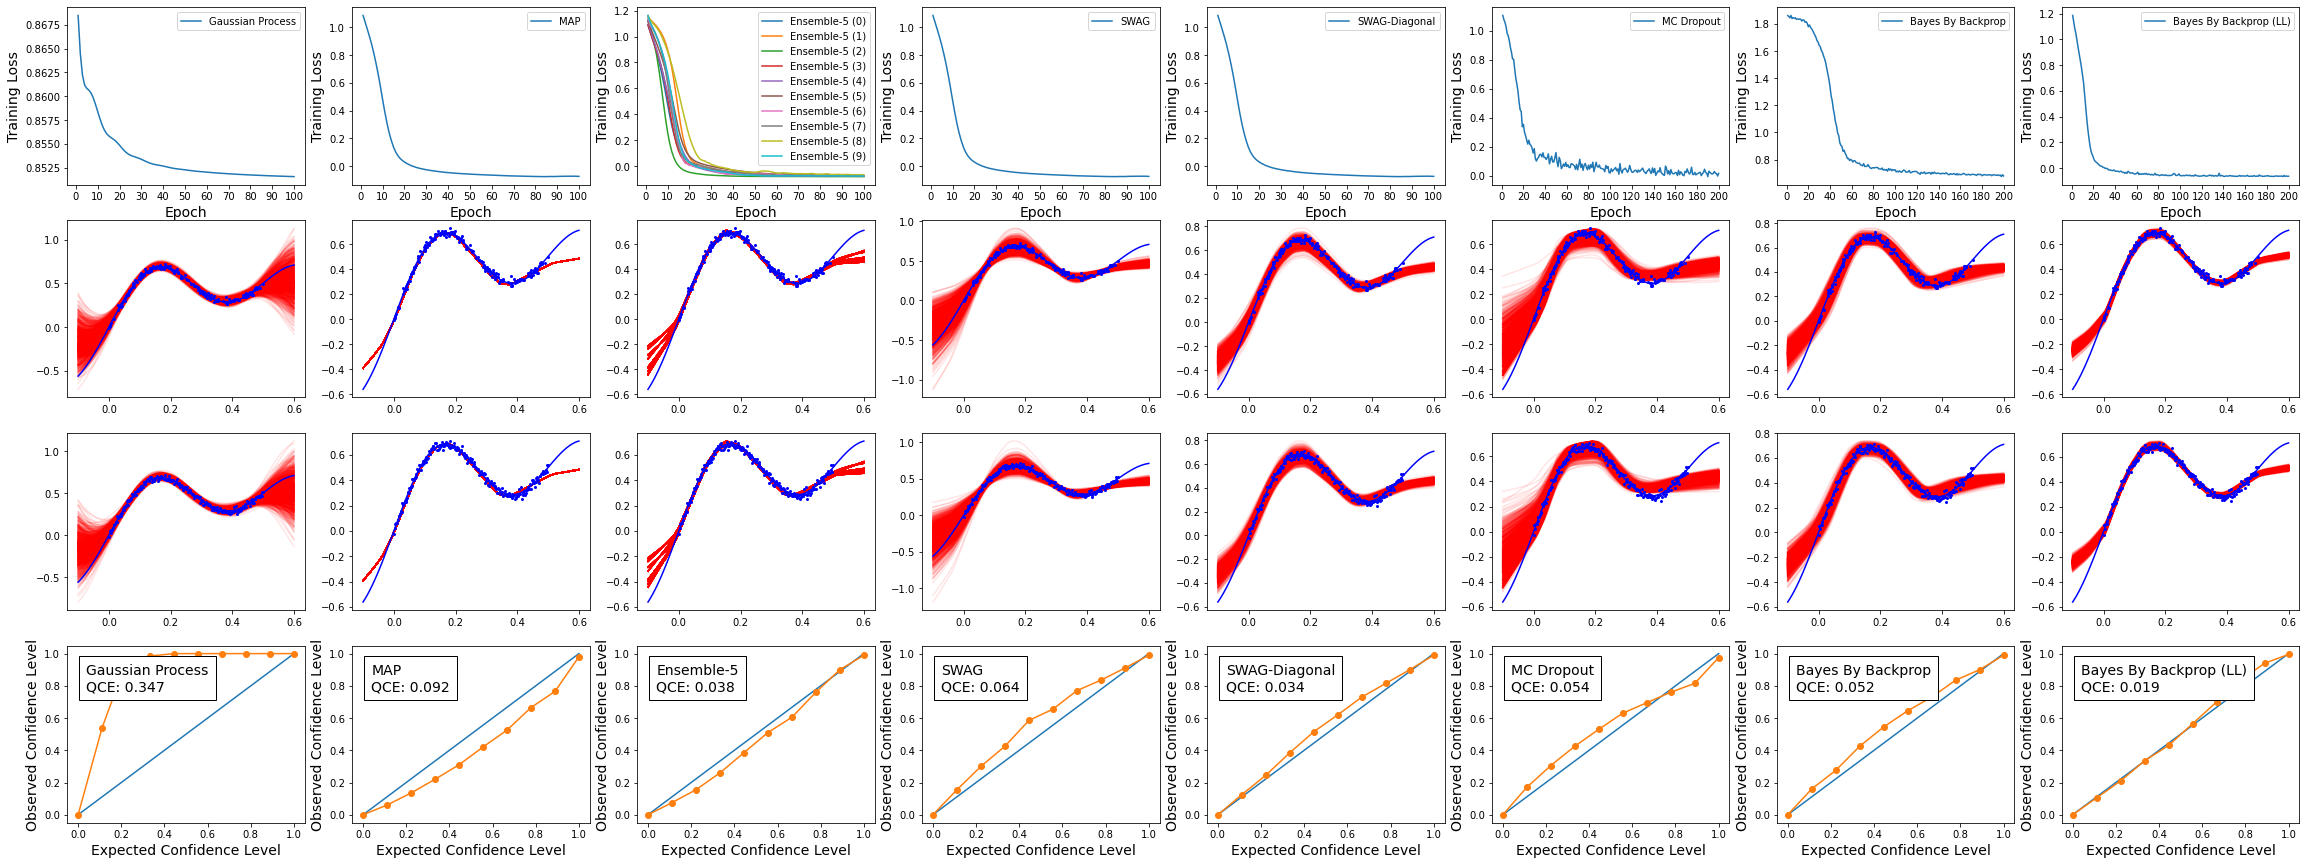

In [25]:
torch.manual_seed(42)
dataset = toy.TrigonometricToyDataset([(0, 0.5, 200)], noise)
dataset.plot_dataset(-0.2, 0.7, plt.subplot())

models = train_models(dataset, 20)

fig, results = plot_grid(dataset, dataset.generate_testset(0.0, 0.5, 200, noise), -0.1, 0.6, [
    ("Gaussian Process", models[0], 1000),
    ("MAP", models[1], 1000),
    ("Ensemble-5", models[2], 1000),
    ("SWAG", models[3], 1000),
    ("SWAG-Diagonal", models[4], 1000),
    ("MC Dropout", models[5], 1000),
    ("Bayes By Backprop", models[6], 1000),
    ("Bayes By Backprop (LL)", models[7], 1000)
], device)

#fig.savefig("results/toy/regression_simple.png")

#plot_table("Simple Toy Regression", [[result] for result in results], "results/toy/regression_simple.txt")

Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\U

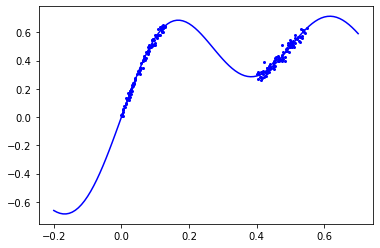

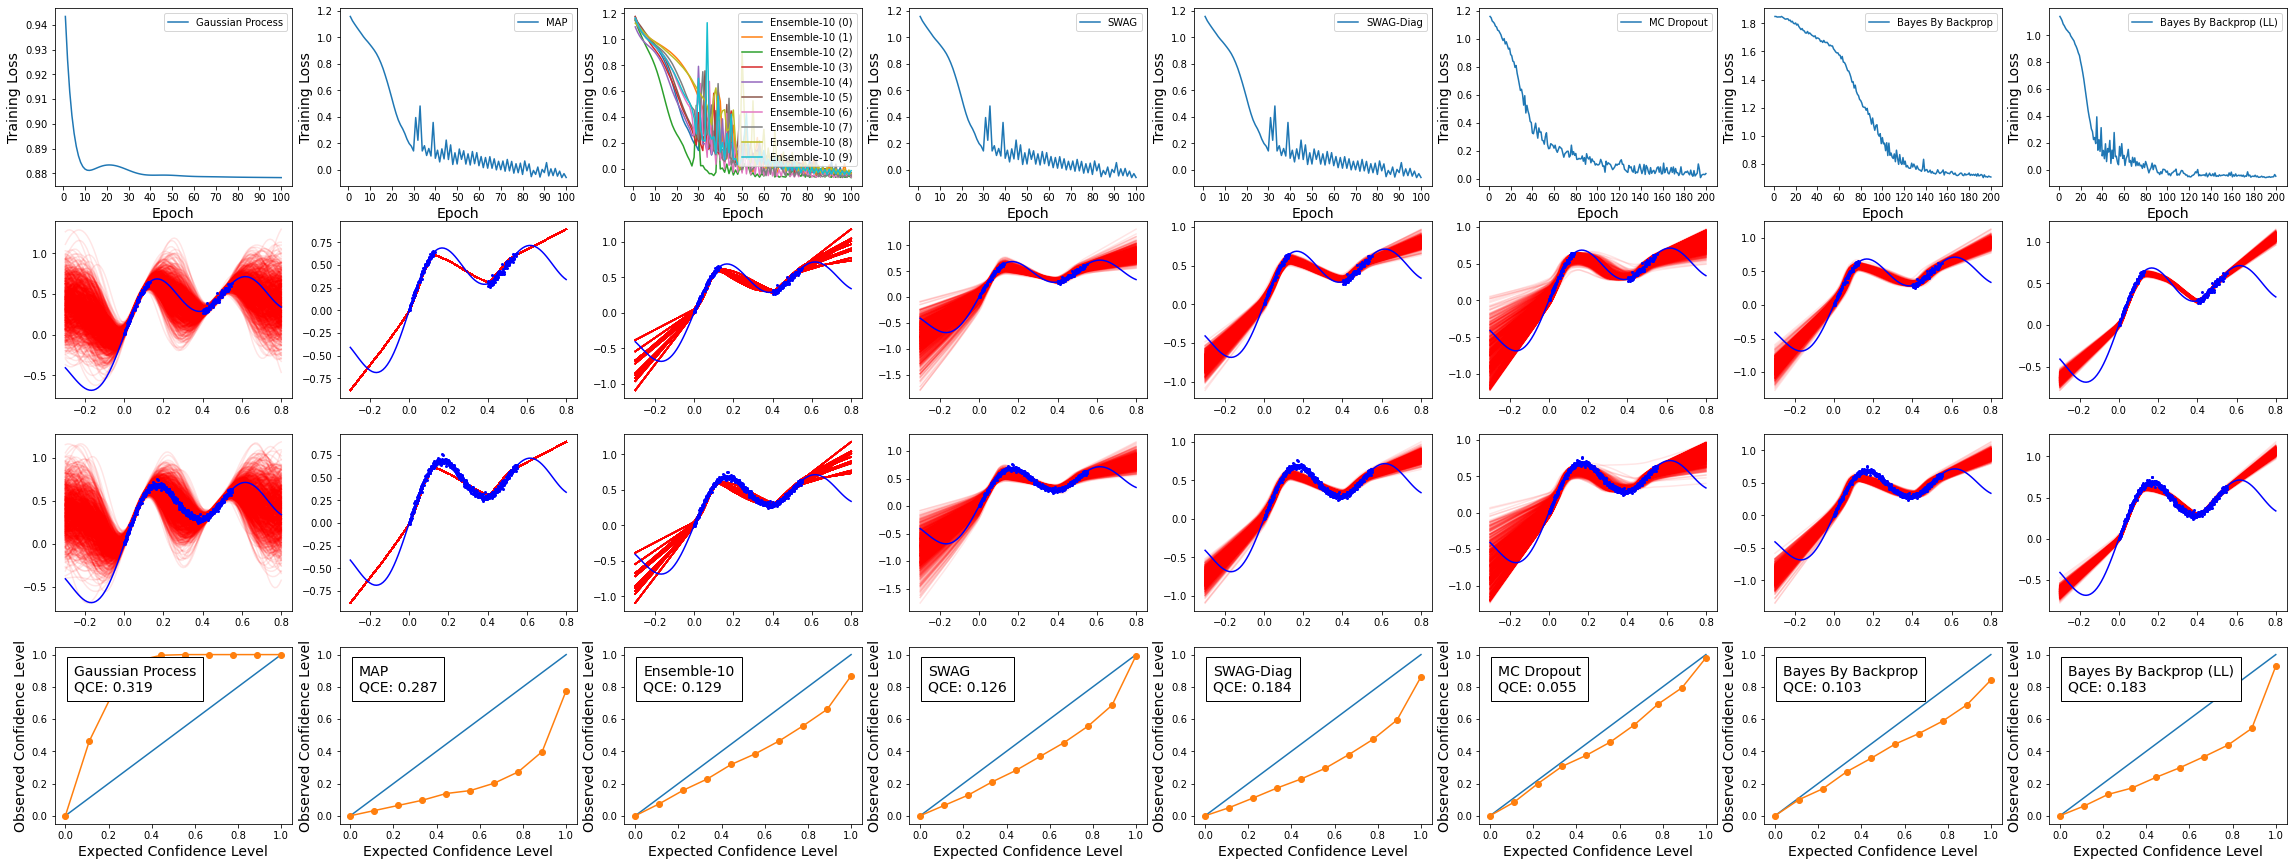

In [6]:
results = [[] for _ in range(8)]
for seed in range(1):
    torch.manual_seed(seed)
    dataset = toy.TrigonometricToyDataset([(0, 0.13, 100), (0.4, 0.55, 100)], noise)
    dataset.plot_dataset(-0.2, 0.7, plt.subplot())
    testset = dataset.generate_testset(0.0, 0.55, 500, noise)
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

    models = train_models(dataset, 20)
    eval_configs = [
        ("Gaussian Process", models[0], 1000),
        ("MAP", models[1], 1000),
        ("Ensemble-10", models[2], 1000),
        ("SWAG", models[3], 1000),
        ("SWAG-Diag", models[4], 1000),
        ("MC Dropout", models[5], 1000),
        ("Bayes By Backprop", models[6], 1000),
        ("Bayes By Backprop (LL)", models[7], 1000)
    ]

    for i, (name, model, samples) in enumerate(eval_configs):
        results[i].append(RegressionResults(testloader, name, model.infer, samples, device, fit_gaussian=False, target_mean=dataset.y_mean, target_std = dataset.y_std))

#plot_table("Gap Toy Regression", results, "results/toy/regression_gap.txt")

fig, results = plot_grid(dataset, testset, -0.3, 0.8, eval_configs, device)
#fig.savefig("results/toy/regression_gap.png")

# store_results(dataset, testset, -0.3, 0.8, [
#     ("gp", models[0], 1000),
#     ("map", models[1], 1000),
#     ("ensemble", models[2], 1000),
#     ("swag", models[3], 1000),
#     ("swag_diag", models[4], 1000),
#     ("mc_dropout", models[5], 1000),
#     ("bbb", models[6], 1000),
#     ("bbb_ll", models[7], 1000)
# ], device)